# Assignment

**Target**:

- Have Model Training and Test Accuracy abive 99%
- Add CLR
- Add image Augmentation

**Results**:
- Parameters: 7,712
- Best Training Accuracy: 99.35
- Best Test Accuracy: 99.30

**Analysis**:
- Added 2nd Max Pooling
- Reduced AveragePooling kernel size 5 to 1
- Added CONV2D 1x1 kernel after average Pooling
- Added stepLR and found that step 4500 is giving better result. The step 4500 is almost equal to 10 epoch and this means reduction of LR after 10 epoch seems to be giving better result and have increased Test accuracy from 99% to 99.30


# Solution

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 7
        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 5
        self.dropout = nn.Dropout(0.1)
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        # x = self.dropout(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        # x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        # x = self.dropout(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [3]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        
        # nn.init.zeros_(m.bias)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
# model.apply(weight_init)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
            Conv2d-8           [-1, 20, 22, 22]           1,800
       BatchNorm2d-9           [-1, 20, 22, 22]              40
             ReLU-10           [-1, 20, 22, 22]               0
          Dropout-11           [-1, 20, 22, 22]               0
        MaxPool2d-12           [-1, 20, 11, 11]               0
           Conv2d-13           [-1, 10, 11, 11]             200
      BatchNorm2d-14           [-1, 10,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.ColorJitter(brightness=0.2, contrast=0.2),
                        # transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    processed = 1
    model.train()
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        # print(len(data))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_losses.append(loss)
        optimizer.step()
        scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print(correct)
        processed += len(data)
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:
model = Net().to(device)

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                               base_lr=0.01,
#                                               max_lr=0.1)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=4500, gamma=0.1)


In [9]:

for epoch in range(1, 15):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.10034193843603134 batch_id=468 Accuracy=92.06: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]



Test set: Average loss: 0.0700, Accuracy: 9799/10000 (97.9900%)



loss=0.018616890534758568 batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0512, Accuracy: 9833/10000 (98.3300%)



loss=0.019046442583203316 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0450, Accuracy: 9859/10000 (98.5900%)



loss=0.021263688802719116 batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:23<00:00, 19.73it/s]



Test set: Average loss: 0.0365, Accuracy: 9873/10000 (98.7300%)



loss=0.06976348906755447 batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]



Test set: Average loss: 0.0347, Accuracy: 9893/10000 (98.9300%)



loss=0.06037931516766548 batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0365, Accuracy: 9892/10000 (98.9200%)



loss=0.009023582562804222 batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]



Test set: Average loss: 0.0302, Accuracy: 9894/10000 (98.9400%)



loss=0.006067000795155764 batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:23<00:00, 19.79it/s]



Test set: Average loss: 0.0294, Accuracy: 9904/10000 (99.0400%)



loss=0.01103139203041792 batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.1200%)



loss=0.0013830781681463122 batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]



Test set: Average loss: 0.0254, Accuracy: 9927/10000 (99.2700%)



loss=0.01614280976355076 batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]



Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.2600%)



loss=0.009140304289758205 batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.3000%)



loss=0.00839062687009573 batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]



Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.2600%)



loss=0.0064856079407036304 batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]



Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.2700%)



In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

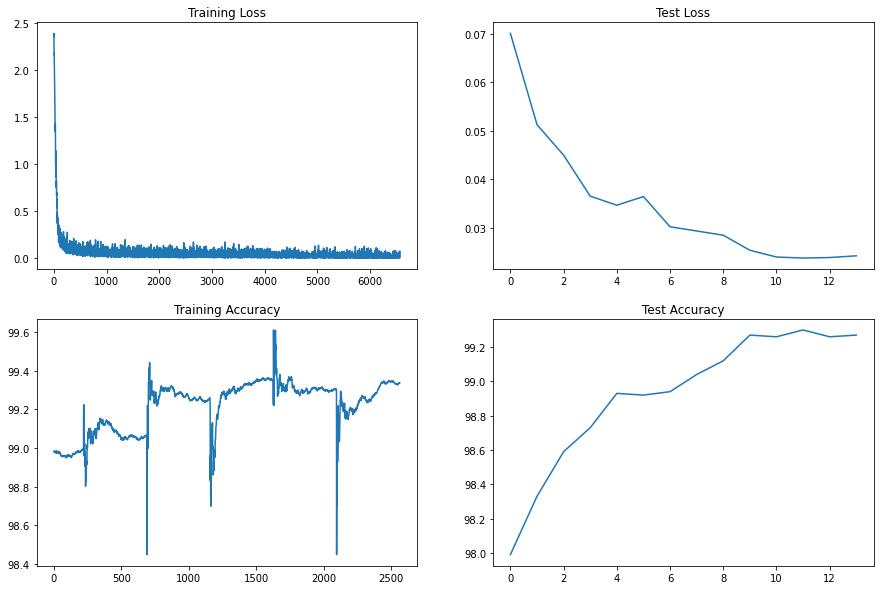

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")